## Libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import warnings
from sklearn.model_selection import KFold
from IPython.display import HTML, display, display_html
import numbers
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore')
%matplotlib inline
import matplotlib
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import pandas_profiling
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
import math as math
from scipy.stats import uniform, truncnorm, randint

In [3]:
# Connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%reload_ext autoreload
%autoreload 2

## Useful Functions

In [0]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [0]:
# Functions to remove collinear features

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)

    return x

## Importing Data

In [0]:
  path_to_drive = '/content/drive/My Drive/Data Science toolbox/Data_cup/'

  train = pd.read_csv(path_to_drive + "train/train.csv")
  building_ownership = pd.read_csv(path_to_drive + "train/building_ownership.csv")
  building_structure = pd.read_csv(path_to_drive + "train/building_structure.csv")
  ward_demographic_data = pd.read_csv(path_to_drive + "train/ward_demographic_data.csv")
  test = pd.read_csv(path_to_drive + "test/test.csv")

In [0]:
list(train)

['building_id',
 'has_geotechnical_risk',
 'has_geotechnical_risk_fault_crack',
 'has_geotechnical_risk_flood',
 'has_geotechnical_risk_land_settlement',
 'has_geotechnical_risk_landslide',
 'has_geotechnical_risk_liquefaction',
 'has_geotechnical_risk_other',
 'has_geotechnical_risk_rock_fall',
 'damage_grade']

In [0]:
list(test)

['building_id',
 'has_geotechnical_risk',
 'has_geotechnical_risk_fault_crack',
 'has_geotechnical_risk_flood',
 'has_geotechnical_risk_land_settlement',
 'has_geotechnical_risk_landslide',
 'has_geotechnical_risk_liquefaction',
 'has_geotechnical_risk_other',
 'has_geotechnical_risk_rock_fall']

### Data wrangling

In [0]:
#merging tables
data = pd.merge(building_structure , building_ownership, how='left')
train = pd.merge(train, data, how = 'left')
train = pd.merge(train,ward_demographic_data, how= 'left')

In [0]:
#merging test
test = pd.merge(test,data, how='left')
test = pd.merge(test, ward_demographic_data, how= 'left')

In [0]:
train.shape

(515937, 51)

In [0]:
test.shape

(221117, 50)

In [9]:
train[['age_building']].describe()

,age_building
count,515937.000000
mean,27.743471
std,72.583940
min,0.000000
25%,10.000000
50%,18.000000
75%,30.000000
max,999.000000


In [0]:
# Dropping unecessary variables/data points

# Dropping outliers in age of building
train=train[~(train['age_building'] > 150)];

# High correlation with ward_id and with has_secondary_use
features_prep = train.drop(columns=['height_ft_pre_eq','plinth_area_sq_ft',
                                    'damage_grade','building_id','district_id',
                                    'vdcmun_id', 'has_secondary_use_agriculture',
                                    'has_secondary_use_hotel','has_secondary_use_rental'])

target = pd.DataFrame(train[['damage_grade']])

# High correlation with ward_id and with has_secondary_use
features_prep_test=test.drop(columns=['height_ft_pre_eq','plinth_area_sq_ft'
                                      ,'building_id','district_id','vdcmun_id'
                                      , 'has_secondary_use_agriculture','has_secondary_use_hotel'
                                      ,'has_secondary_use_rental']) 




In [0]:
# Converting income range category into a mean 
features_prep['income_range_in_thousands']=features_prep['income_range_in_thousands'].replace('0-10', 5.0)
features_prep['income_range_in_thousands']=features_prep['income_range_in_thousands'].replace('10-20', 15.0)
features_prep['income_range_in_thousands']=features_prep['income_range_in_thousands'].replace('20-30', 25.0)
features_prep['income_range_in_thousands']=features_prep['income_range_in_thousands'].replace('30-50', 40.0)
features_prep['income_range_in_thousands']=features_prep['income_range_in_thousands'].replace('50+', 50.0)
features_prep['income_range_in_thousands']=features_prep['income_range_in_thousands'].fillna(0.0)

features_prep_test['income_range_in_thousands']=features_prep_test['income_range_in_thousands'].replace('0-10', 5.0)
features_prep_test['income_range_in_thousands']=features_prep_test['income_range_in_thousands'].replace('10-20', 15.0)
features_prep_test['income_range_in_thousands']=features_prep_test['income_range_in_thousands'].replace('20-30', 25.0)
features_prep_test['income_range_in_thousands']=features_prep_test['income_range_in_thousands'].replace('30-50', 40.0)
features_prep_test['income_range_in_thousands']=features_prep_test['income_range_in_thousands'].replace('50+', 50.0)
features_prep_test['income_range_in_thousands']=features_prep_test['income_range_in_thousands'].fillna(0.0)


# Transforming it into float
features_prep['income_range_in_thousands'].astype(float);
features_prep_test['income_range_in_thousands'].astype(float);

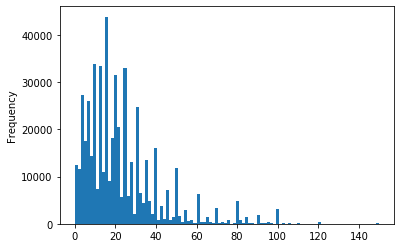

In [12]:
features_prep['age_building'].plot(kind='hist', bins = 100);

In [0]:
# Bucketizing age_building -> creates missing values!
#features_prep['age_building'] = pd.cut(features_prep['age_building'],bins=[10,20,30,40,50,60,70,80,90,100,150])
#features_prep_test['age_building'] = pd.cut(features_prep_test['age_building'],bins=[10,20,30,40,50,60,70,80,90,100,150])


In [13]:
# Checking for missing values
missing_values_table(features_prep)

Your selected dataframe has 42 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
count_families,1,0.0
household_count,1,0.0
avg_hh_size,1,0.0


In [14]:
# Checking for missing values
missing_values_table(features_prep_test)

Your selected dataframe has 42 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
household_count,2,0.0
avg_hh_size,2,0.0


## Target variable analysis

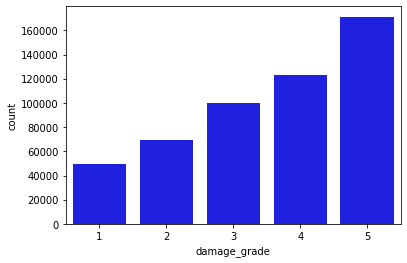

In [15]:
# Target classes distribution
#train['damage_grade'].value_counts().plot(kind='bar')
sns.countplot(x='damage_grade',data=train,color='blue');



1.   The ordinality of the scale. The classes follow an increasing order meaning. A degree of damage of 4 is less severe than 5.
2.   Evaluation metric. In case our model is classifying the damages incorrectly, the RMSE would be punished unproportionally (i.e, predicting degree 1 for a degree 5 sample).
3. Imbalanced dataset, the are far more samples in class 5 than in class.



## Features analysis

### Roof type

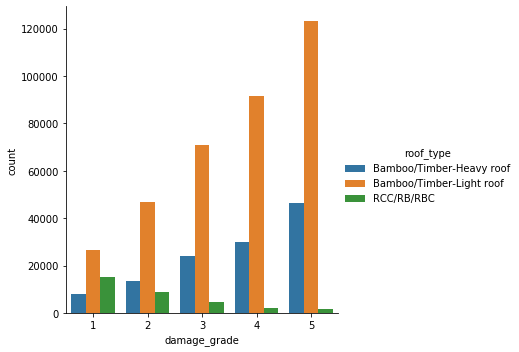

In [16]:
sns.catplot(x='damage_grade', kind='count', hue= 'roof_type',data=train);

Since we have an imbalanced dataset, it is difficult to see how the different categories in an explanatory variable are related to the target class (degree of damage of the building). Since we have an increasing number of samples as we look higher degrees of damage we observe always small counts in degrees of damage 1 and 2 and huge count values in degrees 4 and 5.

For this reason we think it is more useful to represent the counts of each category of the explanatory variables (for example, Bamboo in roof_type) as the proportion of samples within each degree of damage.

So, in the following plots each bin represents the percentage of samples of each roof type in each degree of damage. In degree of damage 1 RCC/RB/RBC represents around 30% of the buldings in that class. In degree of damage 5 it represents almost 0% of the buldings with highly damaged.

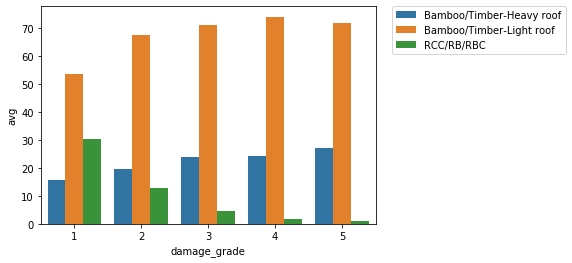

In [17]:
counts_roof = (train.groupby(['damage_grade'])['roof_type']
                     .value_counts(normalize=True)
                     .rename('avg')
                     .mul(100)
                     .reset_index()
                     .sort_values('roof_type'))
sns.barplot(x="damage_grade", y="avg", hue="roof_type", data=counts_roof)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### Foundation type

When we plot the proportion of buildings based on their foundation type in each of the classes of damage severity we observe the same trend.

The proportion of buildings made of RC decreases as the severity of the damage increases. It seems to be a negative correlation between RC and damage. On the other hand Mud material is positively correlated with the damage. In fact, 95% of buildings in degree 5 are made of Mud and just 0.2% of RC.



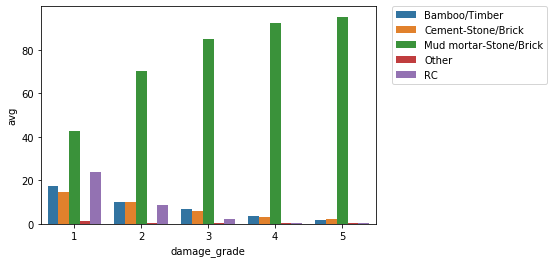

In [18]:
counts_foundation = (train.groupby(['damage_grade'])['foundation_type']
                     .value_counts(normalize=True)
                     .rename('avg')
                     .mul(100)
                     .reset_index()
                     .sort_values('foundation_type'))
sns.barplot(x="damage_grade", y="avg", hue="foundation_type", data=counts_foundation)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [19]:
degree_5 = counts_foundation['damage_grade']==5
counts_foundation[degree_5]

,damage_grade,foundation_type,avg
22,5,Bamboo/Timber,1.663278
21,5,Cement-Stone/Brick,2.362007
20,5,Mud mortar-Stone/Brick,95.149794
23,5,Other,0.545663
24,5,RC,0.279258


### Ground floor type

The same happens when inspecting the ground floor type. RC is the material in almost 40% of the buildings with no damage and just 1.5% in degree 5. Mud floor is found in 88.4% of buildings in degree 5.

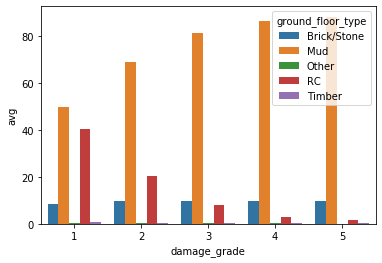

In [53]:
counts_ground_type = (train.groupby(['damage_grade'])['ground_floor_type']
                     .value_counts(normalize=True)
                     .rename('avg')
                     .mul(100)
                     .reset_index()
                     .sort_values('ground_floor_type'))
sns.barplot(x="damage_grade", y="avg", hue="ground_floor_type", data=counts_ground_type);

In [54]:
degree_5_ground = counts_ground_type['damage_grade']==5
counts_ground_type[degree_5_ground]

,damage_grade,ground_floor_type,avg
21,5,Brick/Stone,9.634394
20,5,Mud,88.390353
24,5,Other,0.103991
22,5,RC,1.558703
23,5,Timber,0.312558


### Average household size

In terms of average household size, although there are too few samples outside 4,5 and 6 sizes and might not be significant, there is a decay in buildings with a damage degree 5 and an increase of degree 1 households of size 6, 7 and 8.

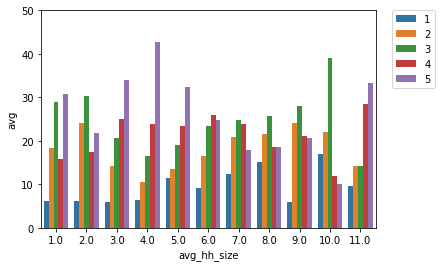

In [50]:
avg_hh_size_avg = (train.groupby(['avg_hh_size'])['damage_grade']
                     .value_counts(normalize=True)
                     .rename('avg')
                     .mul(100)
                     .reset_index()
                     .sort_values('avg_hh_size'))
sns.barplot(x="avg_hh_size", y="avg", hue="damage_grade", data=avg_hh_size_avg)
plt.xlim(-0.5, 10.5)
plt.ylim(0, 50)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Nevertheless, we plot the histograms showing the absolute number of counts and realize the are almost no samples from size 7 onwards.

Amost every building has an average household size of 4, 5 and 6. Size 6 seems to be the safer of those 3.

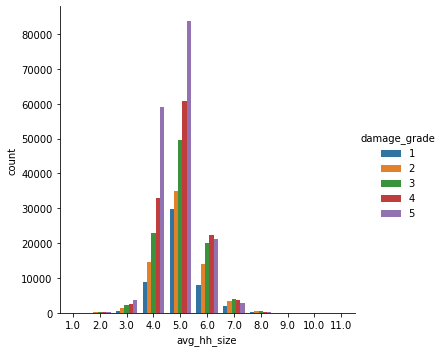

In [51]:
sns.catplot(x='avg_hh_size', kind='count', hue= 'damage_grade',data=train)
plt.xlim(-0.5, 10.5);

### Plinth area

The smaller the plinth area, the higher risk of severe damage the building has. Although there is not a big difference, it can be observed that bigger plinth areas lead to safer buildings. The following plot shows the average plinth area of the constructions in each damage degree.

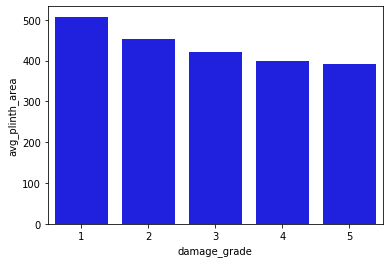

In [0]:
plinth_area_sq_ft = (train.groupby(['damage_grade'])['plinth_area_sq_ft']
                     .mean()
                     .rename('avg_plinth_area')
                     .reset_index())
sns.barplot(x='damage_grade',y='avg_plinth_area',data=plinth_area_sq_ft,color='blue');

### Ward_id analysis

A priori Ward_id seems a simple identifier which has to be taken out of any predictive model. However, we suspect this can have a geographical meaning, which could be of great interest when dealing with such a geographic dependent issue like an earthquake.

In order to investigate it, we use a density estimation plot which represents the the probability of finding a degree of damage taking as a function of the ward_id.

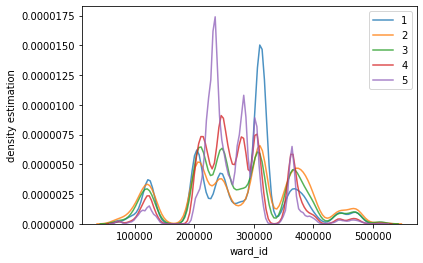

In [68]:
# Plot each score in a density plot
scores=[1,2,3,4,5]
for score in scores:
    # Select the score
    subset = train[train['damage_grade'] == score]
    
    # Density plot of frequency of raising hands
    ax = sns.kdeplot(subset['ward_id'],
               label = score, shade = False, alpha = 0.8);

ax.set(xlabel='ward_id', ylabel='density estimation')
plt.show();

It can be observed peaks in the denstiy curves which potentially represents buildings more close to the epicenter of the earthquakes. The heights of each damage class peaks and the order in which they appear could represent the magnitude of the earthquake.

For example, buildings with ward_id in the range [100000,150000] (first hill from the left) appears to have suffered a light earthquake since the majority of buildings were slightly damaged and a small proportion were highly damaged. However, in buildings with ward_id in the range [200000,250000] a 5-degree damaged density peak can be found. A huge magnitude earthquake or/and a great amount of constructions close to the epicenter are found there.

## Feature engineering

One hot encoding of the categorical values (train set)

In [0]:
# Select the numerical columns
numeric_subset = features_prep.select_dtypes('number')
# Select the categorical columns
categorical_subset=features_prep.select_dtypes('object')

print(list(categorical_subset))

# One hot encode categorical subset
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features_one_hot = pd.concat([numeric_subset, categorical_subset], axis = 1)

features_one_hot.shape

['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']


(512979, 72)

One hot encoding of the categorical values (test set)

In [0]:
# Select the numerical columns
numeric_subset_test = features_prep_test.select_dtypes('number')
# Select the categorical columns
categorical_subset_test=features_prep_test.select_dtypes('object')

print(list(categorical_subset_test))

        
# One hot encode categorical subset
categorical_subset_test = pd.get_dummies(categorical_subset_test)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features_one_hot_test = pd.concat([numeric_subset_test, categorical_subset_test], axis = 1)

features_one_hot_test.shape

['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']


(221117, 72)

Missing values imputation

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Create an imputer object with a median filling strategy
#imputer = Imputer(strategy='median')

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(features_one_hot)

features = imputer.transform(features_one_hot)
features_test=imputer.transform(features_one_hot_test)

Train/Test set normalization

In [0]:
scaler = MinMaxScaler()

# Fit on the training data
scaler.fit(features)

# Transform both the training and testing data
features = scaler.transform(features)
features_test = scaler.transform(features_test)

## Modelling

In [0]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
model = RandomForestRegressor(random_state=60)

Train/Validation split

In [0]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.33, random_state=42)

Model fit and predictions

In [75]:
model.fit(X_train, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=60, verbose=0, warm_start=False)

In [0]:
# Rounding regressor prediction to integer values
y_pred_train=np.around(model.predict(X_train))
y_pred_val=np.around(model.predict(X_val))

#Bound predictions outside range [1,5]
def limiting(predictions):
  for i in range(len(predictions)):
    if predictions[i] == 0:
      predictions[i] = 1
    if predictions[i] == 6:
      predictions[i]=5
  return predictions

y_pred_train = limiting(y_pred_train)
y_pred_val = limiting(y_pred_val)

In [77]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_val, y_pred_val))
print(rmse)

0.9512527199430373


Model training with full training set

In [79]:
model.fit(features, target.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=60, verbose=0, warm_start=False)

Predictions in test set

In [0]:
y_pred=np.around(model.predict(features_test))
y_pred = limiting(y_pred)

Submission file

In [82]:
submission=pd.DataFrame(test[['building_id']])
submission['damage_grade']=np.around(y_pred)
submission.head(5)

,building_id,damage_grade
0,680648,2.0
1,339540,4.0
2,487192,5.0
3,571276,3.0
4,326396,5.0


In [0]:
submission.to_csv(path_to_drive+'submission.csv', index=False)

### Feature importance

In [84]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(features_one_hot), 
                                'importance': model.feature_importances_})

# Show the top 10 most important features
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)
feature_results.head(10)

,feature,importance
0,ward_id,0.333927
1,foundation_type_Mud mortar-Stone/Brick,0.162821
2,age_building,0.138264
3,household_count,0.073635
4,has_superstructure_mud_mortar_stone,0.027358
5,count_families,0.019486
6,count_floors_pre_eq,0.018491
7,avg_hh_size,0.018459
8,has_superstructure_cement_mortar_brick,0.017981
9,has_superstructure_timber,0.011062


In [88]:
from sklearn import tree
regressor = tree.DecisionTreeRegressor(max_depth=3)  # limit depth of tree
regressor.fit(features, target.values.ravel())

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

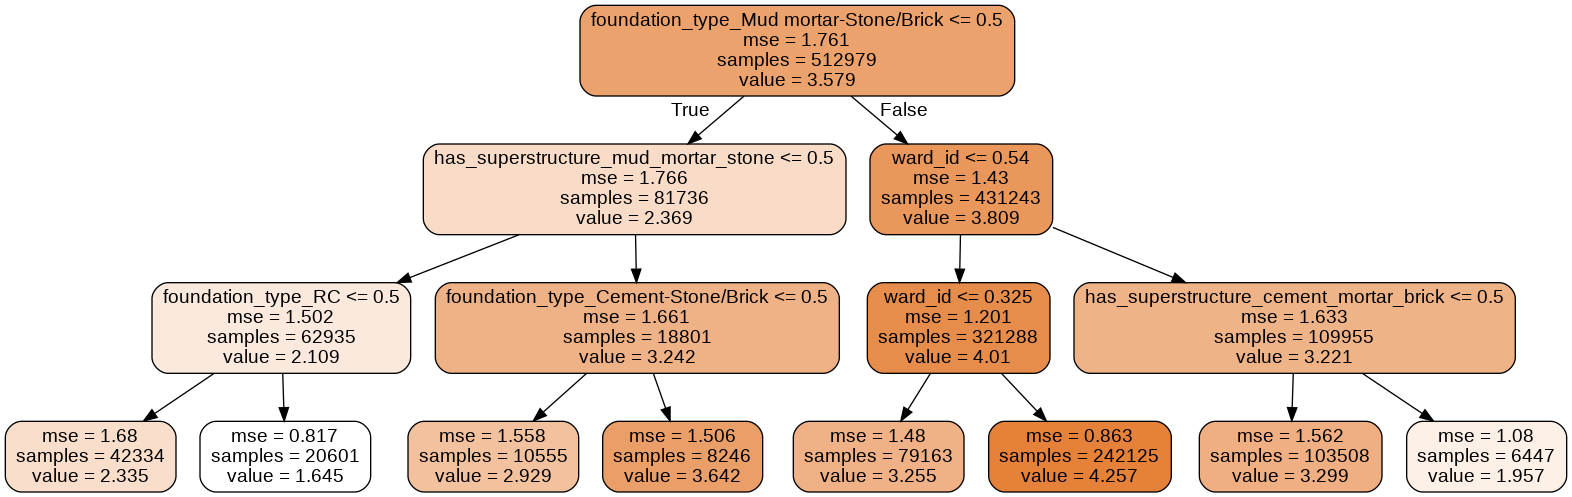

In [89]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(regressor, out_file=dot_data,  
                filled=True, rounded=True, feature_names = list(features_one_hot),
                      max_depth = 3)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Re-running model with only 10 most important features

In [90]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(features_one_hot.columns).index(x) for x in most_important_features]

# Keep only the most important features
features_reduced = features[:, indices]
features_test_reduced = features_test[:, indices]

print('Most important training features shape: ', features_reduced.shape)
print('Most important testing  features shape: ', features_test_reduced.shape)

Most important training features shape:  (512979, 10)
Most important testing  features shape:  (221117, 10)


In [0]:
model.fit(features_reduced, target.values.ravel())

y_pred=np.around(model.predict(features_test_reduced))

for i in range(len(y_pred)):
  if y_pred[i] == 0:
    y_pred[i] = 1
  if y_pred[i] == 6:
    y_pred[i]=5

submission=pd.DataFrame(test[['building_id']])
submission['damage_grade']=np.around(y_pred)

#submission.to_csv(path_to_drive+'test10.csv', index=False)